<a href="https://colab.research.google.com/github/chaturvediajay/AngularjsRestapiDemo/blob/master/TicTacToe_Agent_tavishaggarwal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PG Diploma - Machine Learning and Artificial Intelligence

# Assignment - Tic-Tac-Toe - Solution

#### By:

    Prateek Ralhan
    
#### Let us start by stating the objective that we need to accomplish through this assignment.

### Objective:

In this assignment, we need to build an RL agent that learns to play Numerical Tic-Tac-Toe with odd numbers (the agent will always make the first move). we need to train our agent using Q-Learning. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. If our agent wins the game, it gets 10 points, if the environment wins, the agent loses 10 points. And if the game ends in a draw, it gets 0. Also, we want the agent to win in as few moves as possible, so for each move, it gets a -1 point.


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# copy file there
!cp /content/drive/MyDrive/al_ml_project/Reinforcement-Learning-Numerical-Tic-Tac-Toe/TCGame_Env_tavishaggarwal.py /content

#### Importing libraries

In [18]:
# Importing the necessary libraries

from TCGame_Env_tavishaggarwal import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [19]:
# Importing tictactoe class from environment file

env = TicTacToe()

In [20]:

# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [21]:

# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [22]:

# Defining a function which will add new Q-values to the Q-dictionary. 

def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy

In [23]:
# Defining epsilon-greedy policy here:

def epsilon_greedy(state, time):
#     epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()
    if z > epsilon:
        # ===> Q value fetch max value
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)
    else:
        # ===> random action generation
        agent_actions, env_actions = env.action_space(state)
        action = random.choice(list(agent_actions))
    return action


#### Tracking the state-action pairs for checking convergence

In [24]:

# Initialising Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
rewards_tracked =  {(2,1):0,(5,5):0, (8,3): 0, (9,7):0}

In [25]:

# Initialising states to be tracked

def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-1-x-x-x-x',(7,5)),('x-5-x-x-x-x-5-7-x',(8,2))]
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        state1 = Q_state(state)
        States_track[state1][action] = []  
        


initialise_tracking_states()

In [26]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [27]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [28]:
initialise_tracking_states()

#### Defining hyperparameters

In [29]:
# EPISODES = 15000000
EPISODES = 20000

LR = 0.01   # learning rate
GAMMA = 0.91

max_epsilon = 1.0
min_epsilon = 0.001

threshold = 2000      
policy_threshold = 30000

### Q-update loop

In [30]:
start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe()
    curr_state = env.state
    isTerminated = False
    add_to_dict(curr_state)
    total_reward = 0

    while not isTerminated:
        current_state_ele = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, isTerminated = env.step(curr_state, curr_action)

        next_state_ele = Q_state(next_state)
        add_to_dict(next_state)

        if isTerminated:
            Q_dict[current_state_ele][curr_action] += LR * (
                (reward - Q_dict[current_state_ele][curr_action]))
        else:
            max_next = max(Q_dict[next_state_ele],
                           key=Q_dict[next_state_ele].get)
            Q_dict[current_state_ele][curr_action] += LR * (
                (reward + (GAMMA * (Q_dict[next_state_ele][max_next]))) -
                Q_dict[current_state_ele][curr_action])

        curr_state = next_state
        total_reward += reward

    # Tracking the Q-Values here
    
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()

    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    # Saving the Policy here
    
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')

elapsed_time = time.time() - start_time
save_obj(States_track, 'States_tracked')
save_obj(Q_dict, 'Policy')
print(elapsed_time)                                               

30.9205961227417


#### Check the Q-dictionary

In [31]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.9515633667948092,
              (0, 3): -0.9441125248192755,
              (0, 5): -0.9385700179220244,
              (0, 7): -2.3032339245971105,
              (0, 9): -1.9863579915955076,
              (1, 1): -0.9596931261083363,
              (1, 3): -0.9499341518075666,
              (1, 5): -0.9567623538236999,
              (1, 7): -1.614381729530404,
              (1, 9): -1.8905531021367974,
              (2, 1): -0.9465727307477867,
              (2, 3): -0.9435435675873425,
              (2, 5): -0.9319472196761146,
              (2, 7): -2.173707379158489,
              (2, 9): -2.113526640609607,
              (3, 1): -0.9601284162413478,
              (3, 3): -0.9602217276359717,
              (3, 5): -0.9410020202309022,
              (3, 7): -2.2630373934937156,
              (3, 9): -1.6902319020942211,
              (4, 1): -0.9502936694353111,
              (4, 3): -0.9172075790077302,
              (4, 

In [32]:
len(Q_dict)

47264

In [33]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [34]:
# Write the code for plotting the graphs for state-action pairs tracked

### Epsilon - decay check

In [35]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

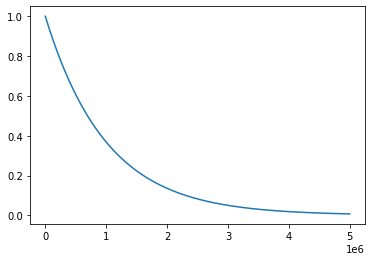

In [36]:
plt.plot(time, epsilon)
plt.show()

In [37]:
###############################################################################################################
#                                                                                                             #
#                                          Compiled By:                                                       #
#                                         Prateek Ralhan                                                      #
#                                                                                                             #
###############################################################################################################